# New CRT Tagging Exploration

### --Shuaixiang (Shu)   
### --Jun 15, 2024

<br />
<br />

## Cosmic flux:

Cosmic flux used here is the classical cos function:

$$
I\left(\theta\right)=I_0\cos^2\theta
$$

where $\theta$ is the zenith angle

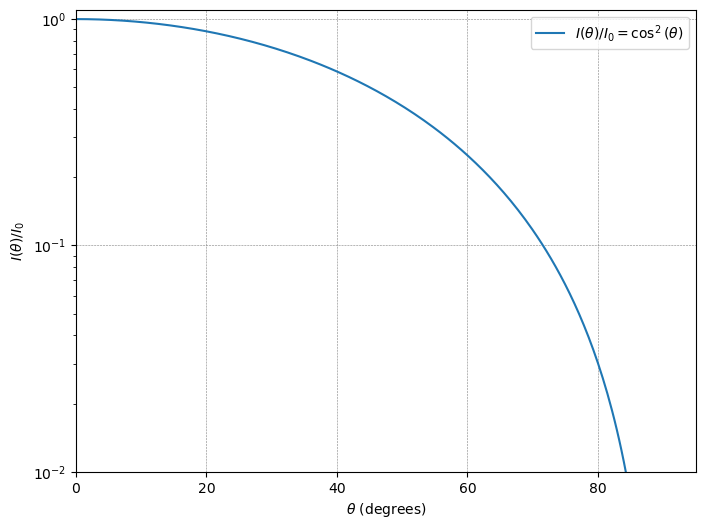

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#Define the function I = cos^2(theta), with theta in radians
def I(theta):
    return np.cos(theta)**2

#Generate a range of theta values in degrees
theta_degrees = np.linspace(0, 360, 1000)

#Convert degrees to radians
theta_radians = np.deg2rad(theta_degrees)

#Compute the function values for each theta
I_values = I(theta_radians)


plt.figure(figsize=(8, 6))
plt.plot(theta_degrees, I_values, label=r'$I(\theta) / I_0 = \cos^2(\theta)$')

plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$I(\theta) / I_0$')
plt.xlim(0, 95)
plt.ylim(0.01, 1.1)
plt.yscale('log')
plt.grid(color='gray', linestyle='--', linewidth=0.4, zorder=0)
plt.legend()
plt.show()

<br />
<br />
<br />

## Define generator of $\theta$ with the pdf as normalized flux function:

In [3]:
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

#Step 1: Define and normalize the function---
def I(theta):
    return np.cos(theta)**2

integral, _ = integrate.quad(I, 0, np.pi * 0.5) #the range is [0, pi/2]

def normalized_I(theta):
    return I(theta) / integral


#Step 2: Create the CDF---
def CDF(theta):
    cdf, _ = integrate.quad(normalized_I, 0, theta)
    return cdf

def inverse_CDF(u):
    return fsolve(lambda theta: CDF(theta) - u, 0)[0]


#Step 3: Create generator---
def generate_theta(size=1):
    u = np.random.uniform(0, 1, size)
    return np.array([inverse_CDF(ui) for ui in u])




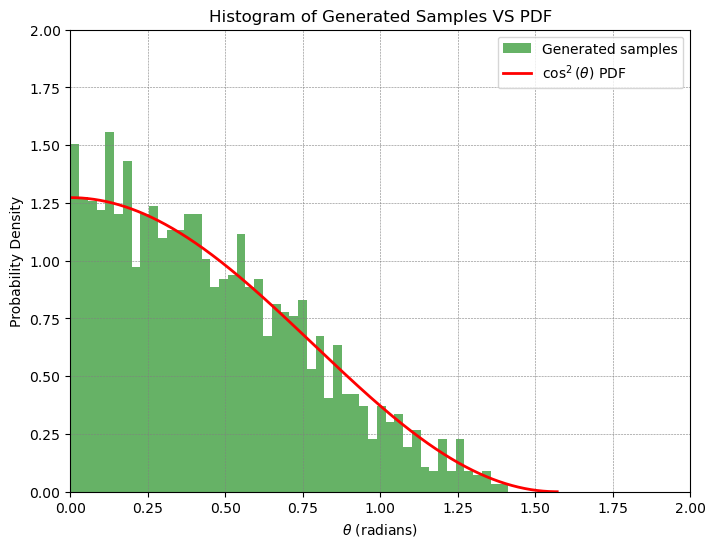

In [4]:
#Test such generator---
random_thetas = generate_theta(2000)


#Plot---
plt.figure(figsize=(8, 6))
plt.hist(random_thetas, bins=50, density=True, alpha=0.6, color='g', label='Generated samples')

#Plot the normalized PDF for comparison
theta_vals = np.linspace(0, np.pi*0.5, 1000)
pdf_vals = normalized_I(theta_vals)
plt.plot(theta_vals, pdf_vals, 'r-', lw=2, label=r'$\cos^2(\theta)$ PDF')

plt.xlabel(r'$\theta$ (radians)')
plt.ylabel('Probability Density')
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.title('Histogram of Generated Samples VS PDF')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.4, zorder=0)
plt.show()



<br />
<br />

## Define straight line in 3D space---

### To fit protoDUNE-VD geometry: $\theta$ (zenith angle) is from x to yz plane; $\phi$ is from y to x

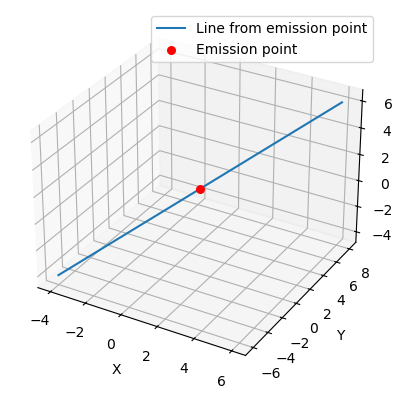

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Function to get the parametric expression of the line
def get_line_emission(emission_point, theta, phi, t_range):
    x0, y0, z0 = emission_point
    dz = np.sin(theta) * np.sin(phi)
    dy = np.sin(theta) * np.cos(phi) #phi: y to z---
    dx = np.cos(theta) #theta: x to yz plane---
    
    t = np.linspace(t_range[0], t_range[1], 1000)
    x = x0 + t * dx
    y = y0 + t * dy
    z = z0 + t * dz
    
    return x, y, z


#Example usage---
emission_point = (1, 1, 1)  # Emission point
theta = np.pi / 3  # Radians (45 degrees)
phi = np.pi / 5   # Radians (30 degrees)
t_range = [-10, 10]  # Range for the parameter t

x, y, z = get_line_emission(emission_point, theta, phi, t_range)

# Plotting the line
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Line from emission point')
ax.scatter(*emission_point, color='r', s=30, label='Emission point')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

<br />
<br />

## Ray and line segment intersection check---

<br />
In 2D space, the ray starts at $\left(m\left[0\right],\;n\left[0\right]\right)$ (following points stored at $m$, $n$),
while the line segment starts from $\left(x_1,\;y_1\right)$ and ends at $\left(x_2,\;y_2\right)$.

<br />
<br />
The algorithm is provided by ChatGPT and checked by me.



In [6]:
import numpy as np

def ray_segment(x1, y1, x2, y2, m, n):
    D = np.array([m[1] - m[0], n[1] - n[0]])
    
    #Line segment endpoints
    P1 = np.array([x1, y1])
    P2 = np.array([x2, y2])
    
    #Starting point of the ray
    R0 = np.array([m[0], n[0]])
    
    #Direction vector of the line segment
    S = P2 - P1
    
    #Compute the determinant
    denominator = S[0] * D[1] - S[1] * D[0]
    
    #Check if the line segment and ray are parallel
    if np.abs(denominator) < 1e-10:
        return False
    
    #Compute t and s
    t = (D[1] * (R0[0] - P1[0]) - D[0] * (R0[1] - P1[1])) / denominator
    s = (S[1] * (R0[0] - P1[0]) - S[0] * (R0[1] - P1[1])) / denominator
    
    #Check if t is within [0, 1] and s is non-negative
    if 0 < t < 1 and s > 0:
        return True
    
    return False



#Example usage:---------------------------
x1, y1 = 3, 2
x2, y2 = 3, 4
m = [0, 1]
n = [0, 2]

print(ray_segment(x1, y1, x2, y2, m, n))  # Output: True or False


False


<br />

## Check if the ray goes through squares in X, Y, Z planes---

In [7]:
def cross_X(x, y, z, x0, square_corners):

    #Extract corners of the square
    y1, z1 = square_corners[0]
    _, z2 = square_corners[1] #_ stores nothing---
    y2, _ = square_corners[2]
    
    #For projection in x-y plane:
    check1 = ray_segment(x0, y1, x0, y2, x, y)

    #Projection in x-z plane:
    check2 = ray_segment(x0, z1, x0, z2, x, z)
    
    return check1 and check2


def cross_Y(x, y, z, y0, square_corners):

    #Extract corners of the square
    x1, z1 = square_corners[0]
    _, z2 = square_corners[1] #_ stores nothing---
    x2, _ = square_corners[2]
    
    #For projection in x-y plane:
    check1 = ray_segment(x1, y0, x2, y0, x, y)

    #Projection in y-z plane:
    check2 = ray_segment(y0, z1, y0, z2, y, z)
    
    return check1 and check2


def cross_Z(x, y, z, z0, square_corners):

    #Extract corners of the square
    x1, y1 = square_corners[0]
    _, y2 = square_corners[1] #_ stores nothing---
    x2, _ = square_corners[2]
    
    #For projection in x-z plane:
    check1 = ray_segment(x1, z0, x2, z0, x, z)

    #Projection in y-z plane:
    check2 = ray_segment(y1, z0, y2, z0, y, z)
    
    return check1 and check2



#Test------------------------------------
emission_point = (0, 0, 0)
theta = np.pi / 4 
phi = np.pi / 2  
t_range = [0, 100]
x, y, z = get_line_emission(emission_point, theta, phi, t_range)

#(y1, z1), (y1, z2), (y2, z1), (y2, z2)---
squareX = [(1, 2), (1, 4), (3, 2), (3, 4)] 
check_X = cross_X(x, y, z, 3, squareX) #x0=3---
print("check_X: ", check_X)

#(x2, z2), (x2, z3), (x3, z2), (x3, z3)---
squareY = [(2, -2), (2, 2), (-2, -2), (-2, 2)] 
check_Y = cross_Y(x, y, z, 4, squareY) #y0=4---
print("\ncheck_Y: ", check_Y)


#(x2, y2), (x2, y3), (x3, y2), (x3, y3)---
squareZ = [(1, -2), (1, 2), (5, 2), (5, 2)]#Corners of the square on the z0=3 plane
check_Z = cross_Z(x, y, z, 3, squareZ)
print("\ncheck_Z: ", check_Z)


check_X:  False

check_Y:  False

check_Z:  True


<br />
<br />
<br />
<br />

## Functions check muon through Active Volume, Cathode plane, CRT (piercing two crt panels)---

The region of Active Volume:
$$
x\in\left[-340,\;340\right]\;\&\;y\in\left[-300,\;300\right]\;\&\;z\in\left[0,\;300\right]
$$

Cathode plane:
$$
x=0\;\&\;y\in\left[-300,\;300\right]\;\&\;z\in\left[0,\;300\right]
$$

Two CRT panels:
$$
x\in\left[-160,\;340\right]\;\;\&\;y=-588\;\&\;z\in\left[0,\;300\right]
$$
$$
x\in\left[-340,\;160\right]\;\;\&\;y=588\;\&\;z\in\left[0,\;300\right]
$$

<br />
For protoDUNE-VD cryostat geometry (x-drift), the range of x is ~ $x\in\left[-550,\;600\right]$
<br />
To simplify the calculation, all muons start from the plane of $x=800cm$ ($200cm$ above cryostat top face; $460cm$ above top CRP)

<br />

In [8]:
import numpy as np


#Cathode & CRP planes: (y2, z2), (y2, z3), (y3, z2), (y3, z3)---
cathode_crp = [(-300, 0), (-300, 300), (300, 0), (300, 300)]

#CRT planes: (x2, z2), (x2, z3), (x3, z2), (x3, z3)---
crt1 = [(-160, 0), (-160, 300), (340, 0), (340, 300)]
crt2 = [(-340, 0), (-340, 300), (160, 0), (160, 300)]

#sides of active volume:
#(x1, z1), (x1, z2), (x2, z1), (x2, z2)
short = [(-340, 0), (-340, 300), (340, 0), (340, 300)]
#(x1, y1), (x1, y2), (x2, y1), (x2, y2)
long = [(-340, -300), (-340, 300), (340, -300), (340, 300)]




#Define if track cross cathode---
def cross_Cathode(x, y, z):
    x0 = 0 
    check = cross_X(x, y, z, x0, cathode_crp)
    
    if check:
        return True
    else:
        return False


#Define if track cross 2 CRT panels---
def cross_CRT(x, y, z):
    y1 = -588 
    check1 = cross_Y(x, y, z, y1, crt1)
    y2 = 588
    check2 = cross_Y(x, y, z, y2, crt2)

#    print("\nCRT left: ", check1)
#    print("CRT right: ", check2)
    if check1 and check2:
        return True
    else:
        return False


#only through left crt panel---
def cross_crtL(x, y, z):
    y1 = -588 
    check1 = cross_Y(x, y, z, y1, crt1)

#    print("\nCRT left: ", check1)
    if check1:
        return True
    else:
        return False


#only through right crt panel---
def cross_crtR(x, y, z):
    y2 = 588
    check2 = cross_Y(x, y, z, y2, crt2)

#    print("\nCRT right: ", check2)
    if check2:
        return True
    else:
        return False



#Define if track cross Active Volume---
def cross_AV(x, y, z):
    x1 = 340 
    check_x1 = cross_X(x, y, z, x1, cathode_crp)
    x2 = -340 
    check_x2 = cross_X(x, y, z, x2, cathode_crp)    
    y1 = 300
    check_y1 = cross_Y(x, y, z, y1, short)
    y2 = -300
    check_y2 = cross_Y(x, y, z, y2, short)
    z1 = 0
    check_z1 = cross_Z(x, y, z, z1, long)
    z2 = 300
    check_z2 = cross_Z(x, y, z, z2, long)

#    print("\nCRP Top: ", check_x1)
#    print("CRP Bot: ", check_x2)
#    print("Short Right: ", check_y1)
#    print("Short Left : ", check_y2)
#    print("Long Front: ", check_z1)
#    print("Long Back : ", check_z2)    
    
    if check_x1 or check_x2 or check_y1 or check_y2 or check_z1 or check_z2:
        return True
    else:
        return False





#Test---------------------------------------------------
#Test Single cosmic muon---
emission_point = (700, 100, 100) #cm---
theta = np.pi / 20
theta = np.pi - theta #Make sure the track is downward---
phi = np.pi * 0.5 
t_range = [0, 2000] #in units of cm--
x, y, z = get_line_emission(emission_point, theta, phi, t_range)

print("Cross cathode plane? ", cross_Cathode(x, y, z))

print("\nCross CRT panles? ", cross_CRT(x, y, z))

print("\nCross Active Volume? ", cross_AV(x, y, z))


Cross cathode plane?  True

Cross CRT panles?  False

Cross Active Volume?  True


<br />
<br />
<br />
<br />

## The main function (I): Generate $\mu^-$ Emission Vertex & $\mu^-$ distribution per vertex

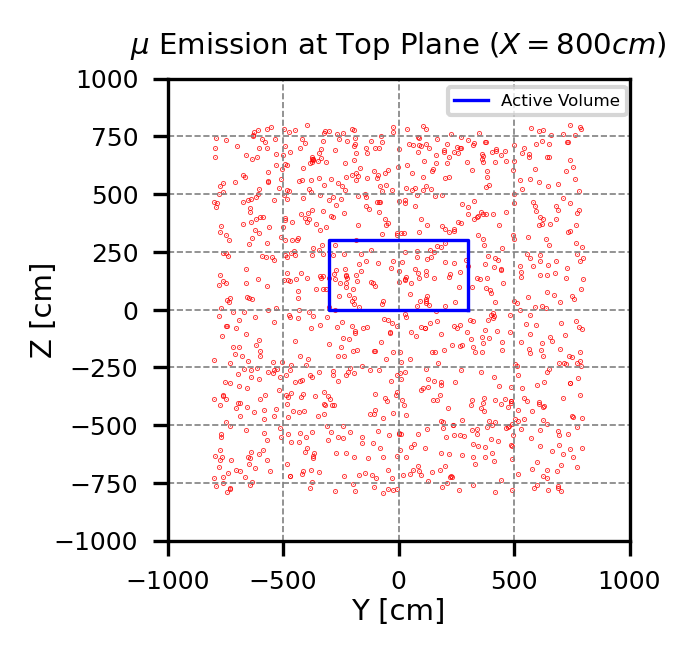

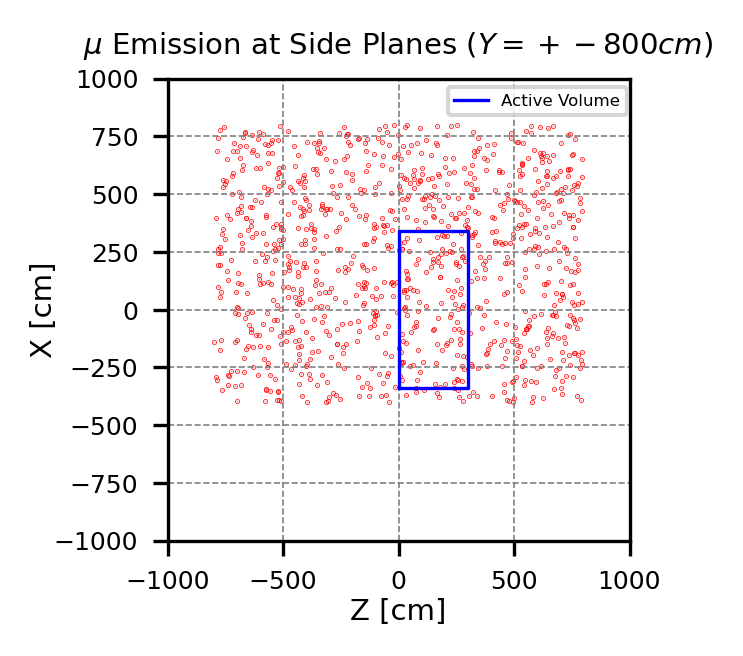

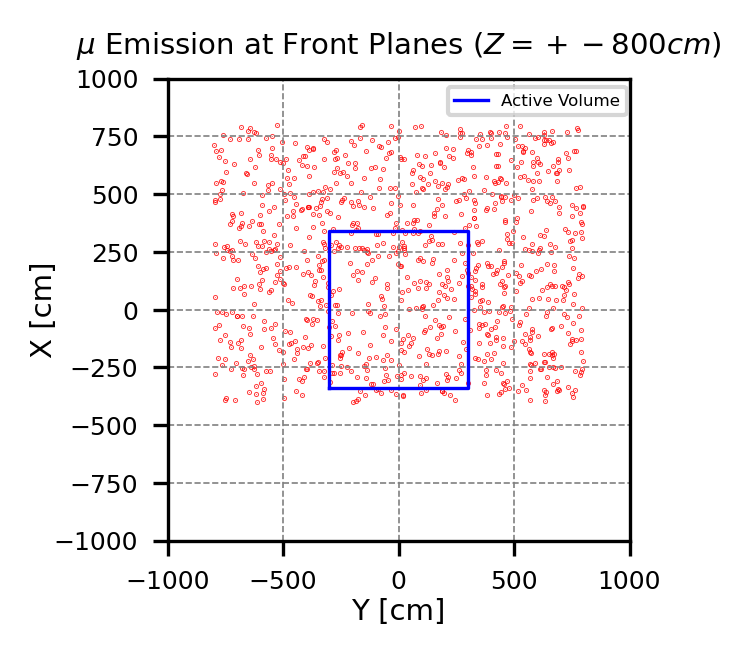

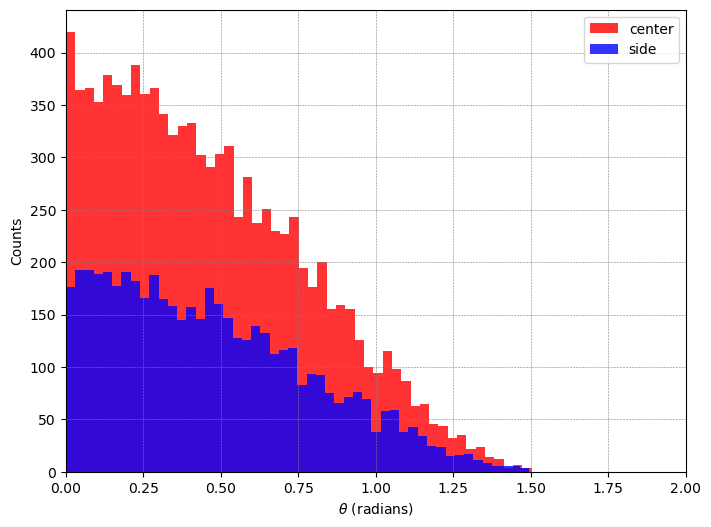

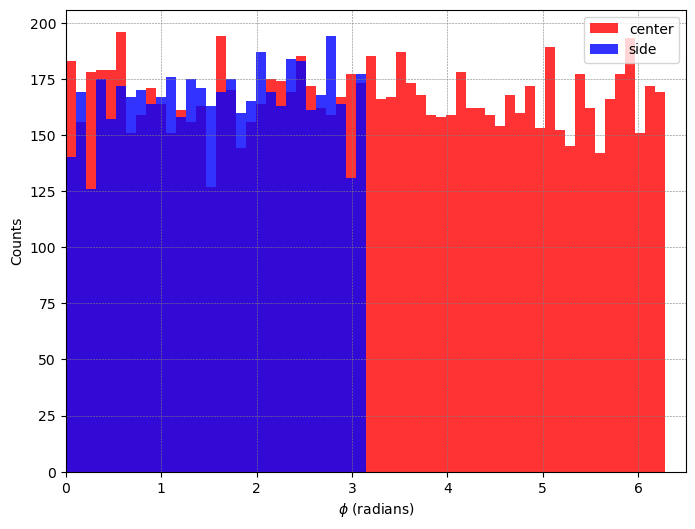

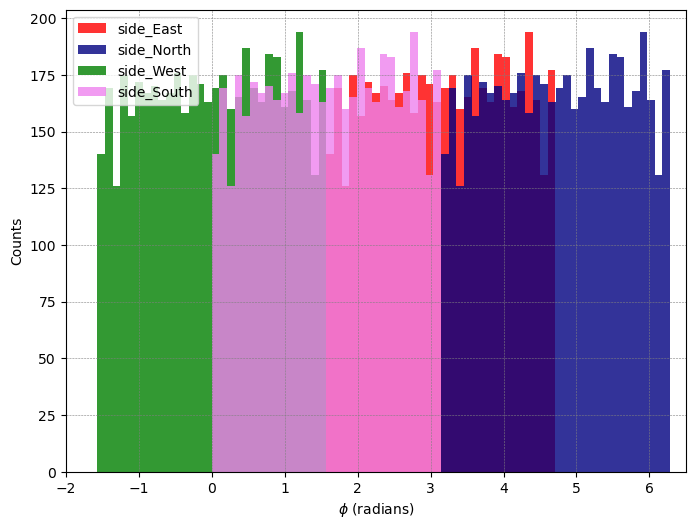

In [16]:
import numpy as np


#Top (X) plane---
#====================================================
#Top (X) plane---
top_Y = np.random.uniform(-800, 800, 1000)#increase to 500, 1k, 10k---
top_Z = np.random.uniform(-800, 800, 1000)

#Left (-Y) & Right (+Y) Side plane---
side_Z = np.random.uniform(-800, 800, 1000)#increase to 500, 1k, 10k---
side_X = np.random.uniform(-400, 800, 1000)

#Front (-Z & +Z)planes---
front_Y = np.random.uniform(-800, 800, 1000)#increase to 500, 1k, 10k---
front_X = np.random.uniform(-400, 800, 1000)
#====================================================




#Top (X) plane---------------------------
plt.figure(figsize=(3,2),dpi=300)

plt.scatter(top_Y,top_Z, c='r',s=0.05, alpha=0.8)

# Define the AV frame---
cage_y = [300, 300, -300, -300, 300]
cage_z = [0, 300, 300, 0, 0]
plt.plot(cage_y, cage_z, color="blue", linewidth=0.8, linestyle='-', label='Active Volume')

plt.xlabel('Y [cm]', labelpad=1, fontsize=7)
plt.ylabel('Z [cm]', labelpad=-1, fontsize=7)
plt.tick_params(labelsize=6)#set the size of ticks---
plt.axis('scaled')
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.title('$\mu$ Emission at Top Plane ($X = 800cm$)', fontsize=7)
plt.grid(color='gray', linestyle='--', linewidth=0.4, zorder=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.8, 1.0), fontsize=6, markerscale=5, ncol=3, prop={'size': 4})
plt.show()


#Side (-Y & + Y) plane---------------------------
plt.figure(figsize=(3,2),dpi=300)

plt.scatter(side_Z, side_X, c='r',s=0.05, alpha=0.8)

# Define the AV frame---
cage_z = [0, 300, 300, 0, 0]
cage_x = [-340, -340, 340, 340, -340]
plt.plot(cage_z, cage_x, color="blue", linewidth=0.8, linestyle='-', label='Active Volume')

plt.xlabel('Z [cm]', labelpad=1, fontsize=7)
plt.ylabel('X [cm]', labelpad=-1, fontsize=7)
plt.tick_params(labelsize=6)#set the size of ticks---
plt.axis('scaled')
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.title('$\mu$ Emission at Side Planes ($Y = +-800cm$)', fontsize=7)
plt.grid(color='gray', linestyle='--', linewidth=0.4, zorder=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.8, 1.0), fontsize=6, markerscale=5, ncol=3, prop={'size': 4})
plt.show()


#Front (-Z & + Z) plane---------------------------
plt.figure(figsize=(3,2),dpi=300)

plt.scatter(front_Y, front_X, c='r',s=0.05, alpha=0.8)

# Define the AV frame---
cage_z = [-300, 300, 300, -300, -300]
cage_x = [-340, -340, 340, 340, -340]
plt.plot(cage_z, cage_x, color="blue", linewidth=0.8, linestyle='-', label='Active Volume')

plt.xlabel('Y [cm]', labelpad=1, fontsize=7)
plt.ylabel('X [cm]', labelpad=-1, fontsize=7)
plt.tick_params(labelsize=6)#set the size of ticks---
plt.axis('scaled')
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.title('$\mu$ Emission at Front Planes ($Z = +-800cm$)', fontsize=7)
plt.grid(color='gray', linestyle='--', linewidth=0.4, zorder=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.8, 1.0), fontsize=6, markerscale=5, ncol=3, prop={'size': 4})
plt.show()











#Generate muons------------------------------------------------------------------------

#Zenith Angle & Azimuth angle distribution------
#====================================================
thetaS_center = generate_theta(10000) #increase to 8000
thetaS_side = generate_theta(5000) #4000
#thetaS_diag = generate_theta(1000) #1000

azi_center = np.random.uniform(0, 2 * np.pi, 10000)
azi_side = np.random.uniform(0, np.pi, 5000)
#azi_diag = np.random.uniform(0, 0.5 * np.pi, 1000)

azi_side_E = azi_side + 0.5 * np.pi #In z-y plane, east side---
azi_side_N = azi_side + np.pi
azi_side_W = azi_side - 0.5 * np.pi
azi_side_S = azi_side

#azi_diag_NE = azi_diag + np.pi
#azi_diag_NW = azi_diag + 1.5 * np.pi
#azi_diag_SW = azi_diag
#azi_diag_SE = azi_diag + 0.5 * np.pi
#====================================================



#Plot---
plt.figure(figsize=(8, 6))
plt.hist(thetaS_center, bins=50, alpha=0.8, color='r', label='center')
plt.hist(thetaS_side, bins=50, alpha=0.8, color='b', label='side')
#plt.hist(thetaS_diag, bins=50, alpha=0.8, color='g', label='diagonal')

plt.xlabel(r'$\theta$ (radians)')
plt.ylabel('Counts')
plt.xlim(0, 2)
#plt.ylim(0, 100)
plt.title('')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.4, zorder=0)
plt.show()

#Plot---
plt.figure(figsize=(8, 6))
plt.hist(azi_center, bins=60, alpha=0.8, color='r', label='center')
plt.hist(azi_side, bins=30, alpha=0.8, color='b', label='side')
#plt.hist(azi_diag, bins=15, alpha=0.8, color='g', label='diagonal')

plt.xlabel(r'$\phi$ (radians)')
plt.ylabel('Counts')
plt.xlim(0, 6.5)
#plt.ylim(0, 100)
plt.title('')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.4, zorder=0)
plt.show()

#Plot---
plt.figure(figsize=(8, 6))
plt.hist(azi_side_E, bins=30, alpha=0.8, color='r', label='side_East')
plt.hist(azi_side_N, bins=30, alpha=0.8, color='navy', label='side_North')
plt.hist(azi_side_W, bins=30, alpha=0.8, color='g', label='side_West')
plt.hist(azi_side_S, bins=30, alpha=0.8, color='violet', label='side_South')

plt.xlabel(r'$\phi$ (radians)')
plt.ylabel('Counts')
plt.xlim(-2, 6.5)
#plt.ylim(0, 100)
plt.title('')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.4, zorder=0)
plt.show()


<br />
<br />

## The main function (II): 

## Generate $\mu^-$ at Top Plane & count events crossing AV, cathode, CRTs

In [17]:
import numpy as np

import time
#start time record---
start_record = time.time()



x0 = 800# muon emission x position, in units of cm---
t_range = [0, 2000]#length of track, ray check, NOT important---


count_Total_top = 0 #totoal emission muons---

count_AV_top = 0 #track through active volume---
count_Cathode_top = 0
count_CRT_top = 0

count_CRT_top_only = 0 
count_AV_top_only = 0
count_Cathode_top_only = 0

count_crtL_top = 0
count_crtR_top = 0


for i in range(0, len(top_Y)):
    y0 = top_Y[i]
    z0 = top_Z[i]
    source_point = (x0, y0, z0)

    #Middle region--------------------------------------
    if 0 < z0 < 300:
        for j in range(0, len(thetaS_center)):
            theta = thetaS_center[j]
            theta = np.pi - theta #downward---
            phi = azi_center[j]

            x, y, z = get_line_emission(source_point, theta, phi, t_range)

            count_Total_top += 1
            if cross_AV(x, y, z):
                count_AV_top += 1
            if cross_Cathode(x, y, z):
                count_Cathode_top += 1
            if cross_CRT(x, y, z):
                count_CRT_top += 1
                
            if cross_AV(x, y, z) and not cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                count_AV_top_only += 1
            if cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                count_Cathode_top_only += 1
            if cross_CRT(x, y, z) and not cross_Cathode(x, y, z):
                count_CRT_top_only += 1

    

    #North region--------------------------------------
    if z0 > 300:
        for j in range(0, len(thetaS_side)):
            theta = thetaS_side[j]
            theta = np.pi - theta #downward---
            phi = azi_side_N[j]#North---

            x, y, z = get_line_emission(source_point, theta, phi, t_range)

            count_Total_top += 1
            if cross_AV(x, y, z):
                count_AV_top += 1
            if cross_Cathode(x, y, z):
                count_Cathode_top += 1
            if cross_CRT(x, y, z):
                count_CRT_top += 1

            if cross_AV(x, y, z) and not cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                count_AV_top_only += 1
            if cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                count_Cathode_top_only += 1
            if cross_CRT(x, y, z) and not cross_Cathode(x, y, z):
                count_CRT_top_only += 1




    #South region--------------------------------------
    if z0 < 0:
        for j in range(0, len(thetaS_side)):
            theta = thetaS_side[j]
            theta = np.pi - theta #downward---
            phi = azi_side_S[j]#South---

            x, y, z = get_line_emission(source_point, theta, phi, t_range)

            count_Total_top += 1
            if cross_AV(x, y, z):
                count_AV_top += 1
            if cross_Cathode(x, y, z):
                count_Cathode_top += 1
            if cross_CRT(x, y, z):
                count_CRT_top += 1

            if cross_AV(x, y, z) and not cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                count_AV_top_only += 1
            if cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                count_Cathode_top_only += 1
            if cross_CRT(x, y, z) and not cross_Cathode(x, y, z):
                count_CRT_top_only += 1
            
#            if cross_crtL(x, y, z):
#                count_crtL_top += 1
#            if cross_crtR(x, y, z):
#                count_crtR_top += 1 



    else:
        continue








print("# Total cosmic muons        : ", count_Total_top)
print("\n# events through certain space:")
print("# AV     : ", count_AV_top, "({:.2f}%)".format(count_AV_top/count_Total_top * 100))
print("# Cathode: ", count_Cathode_top)  
print("# CRT    : ", count_CRT_top)

print("# Only AV     : ", count_AV_top_only)
print("# Only Cathode: ", count_Cathode_top_only)  
print("# Only CRT    : ", count_CRT_top_only)

#print("# Cosmic muons cross crtL   : ", count_crtL_top)
#print("# Cosmic muons cross crtR   : ", count_crtR_top)



 
# Calculate total execution time
total_time = time.time() - start_record
print(f"\nTotal execution time: {total_time:.2f} seconds")

# Total cosmic muons        :  5905000

# events through certain space:
# AV     :  1139117 (19.29%)
# Cathode:  601959
# CRT    :  0
# Only AV     :  537158
# Only Cathode:  601959
# Only CRT    :  0

Total execution time: 846.51 seconds


<br />

## Generate $\mu^-$ at Front ($-+z$) Plane & count events crossing AV, cathode, CRTs

In [18]:
import numpy as np

import time
#start time record---
start_record = time.time()



z01 = -800
z02 = 800
t_range = [0, 2000]#length of track, ray check, NOT important---


front_Total = 0 #totoal emission muons---

front_AV = 0 #track through active volume---
front_Cathode = 0
front_CRT = 0

front_CRT_only = 0 
front_AV_only = 0
front_Cathode_only = 0



#For z=-800 -------------------------------
for i in range(0, len(front_Y)):
    y0 = front_Y[i]
    x0 = front_X[i]
    source_point = (x0, y0, z01)#z01=-800

    for j in range(0, len(thetaS_side)):
            theta = np.pi - thetaS_side[j] #downward---
            phi = azi_side_S[j]#South---

            x, y, z = get_line_emission(source_point, theta, phi, t_range)

            front_Total += 1
            if cross_AV(x, y, z):
                front_AV += 1
            if cross_Cathode(x, y, z):
                front_Cathode += 1
            if cross_CRT(x, y, z):
                front_CRT += 1
                
            if cross_AV(x, y, z) and not cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                front_AV_only += 1
            if cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                front_Cathode_only += 1
            if cross_CRT(x, y, z) and not cross_Cathode(x, y, z):
                front_CRT_only += 1
            
    else:
        continue




#For z=800 -------------------------------
for i in range(0, len(front_Y)):
    y0 = front_Y[i]
    x0 = front_X[i]
    source_point = (x0, y0, z02)#z01=800

    for j in range(0, len(thetaS_side)):
            theta = np.pi - thetaS_side[j] #downward---
            phi = azi_side_N[j]#North---

            x, y, z = get_line_emission(source_point, theta, phi, t_range)

            front_Total += 1
            if cross_AV(x, y, z):
                front_AV += 1
            if cross_Cathode(x, y, z):
                front_Cathode += 1
            if cross_CRT(x, y, z):
                front_CRT += 1
                
            if cross_AV(x, y, z) and not cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                front_AV_only += 1
            if cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                front_Cathode_only += 1
            if cross_CRT(x, y, z) and not cross_Cathode(x, y, z):
                front_CRT_only += 1
            
    else:
        continue














print("# Total cosmic muons        : ", front_Total)
print("\n# events through certain space:")
print("# AV     : ", front_AV, "({:.2f}%)".format(front_AV/front_Total*100))
print("# Cathode: ", front_Cathode)  
print("# CRT    : ", front_CRT)

print("# Only AV     : ", front_AV_only)
print("# Only Cathode: ", front_Cathode_only)  
print("# Only CRT    : ", front_CRT_only)





# Calculate total execution time
total_time = time.time() - start_record
print(f"\nTotal execution time: {total_time:.2f} seconds")

# Total cosmic muons        :  10000000

# events through certain space:
# AV     :  316344 (3.16%)
# Cathode:  63224
# CRT    :  0
# Only AV     :  253120
# Only Cathode:  63224
# Only CRT    :  0

Total execution time: 1386.46 seconds


<br />

## Generate $\mu^-$ at Side ($-+y$) Plane & count events crossing AV, cathode, CRTs

In [19]:
import numpy as np

import time
#start time record---
start_record = time.time()



y01 = -800
y02 = 800
t_range = [0, 2000]#length of track, ray check, NOT important---


side_Total = 0 #totoal emission muons---

side_AV = 0 #track through active volume---
side_Cathode = 0
side_CRT = 0

side_CRT_only = 0 
side_AV_only = 0
side_Cathode_only = 0



#For y=-800 -------------------------------
for i in range(0, len(side_Z)):
    z0 = side_Z[i]
    x0 = side_X[i]
    source_point = (x0, y01, z0)#y01=-800

    for j in range(0, len(thetaS_side)):
            theta = np.pi - thetaS_side[j] #downward---
            phi = azi_side_W[j]#West---

            x, y, z = get_line_emission(source_point, theta, phi, t_range)

            side_Total += 1
            if cross_AV(x, y, z):
                side_AV += 1
            if cross_Cathode(x, y, z):
                side_Cathode += 1
            if cross_CRT(x, y, z):
                side_CRT += 1
                
            if cross_AV(x, y, z) and not cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                side_AV_only += 1
            if cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                side_Cathode_only += 1
            if cross_CRT(x, y, z) and not cross_Cathode(x, y, z):
                side_CRT_only += 1
            
    else:
        continue




#For y=800 -------------------------------
for i in range(0, len(side_Z)):
    z0 = side_Z[i]
    x0 = side_X[i]
    source_point = (x0, y02, z0)#y01=800

    for j in range(0, len(thetaS_side)):
            theta = np.pi - thetaS_side[j] #downward---
            phi = azi_side_E[j]#East---

            x, y, z = get_line_emission(source_point, theta, phi, t_range)

            side_Total += 1
            if cross_AV(x, y, z):
                side_AV += 1
            if cross_Cathode(x, y, z):
                side_Cathode += 1
            if cross_CRT(x, y, z):
                side_CRT += 1
                
            if cross_AV(x, y, z) and not cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                side_AV_only += 1
            if cross_Cathode(x, y, z) and not cross_CRT(x, y, z):
                side_Cathode_only += 1
            if cross_CRT(x, y, z) and not cross_Cathode(x, y, z):
                side_CRT_only += 1
            
    else:
        continue












print("# Total cosmic muons        : ", side_Total)
print("\n# events through certain space:")
print("# AV     : ", side_AV, "({:.2f}%)".format(side_AV/side_Total*100))
print("# Cathode: ", side_Cathode)  
print("# CRT    : ", side_CRT)

print("# Only AV     : ", side_AV_only)
print("# Only Cathode: ", side_Cathode_only)  
print("# Only CRT    : ", side_CRT_only)





# Calculate total execution time
total_time = time.time() - start_record
print(f"\nTotal execution time: {total_time:.2f} seconds")

# Total cosmic muons        :  10000000

# events through certain space:
# AV     :  287149 (2.87%)
# Cathode:  66201
# CRT    :  875
# Only AV     :  220762
# Only Cathode:  65512
# Only CRT    :  186

Total execution time: 1388.74 seconds


<br />

## Conclusion:

In [20]:
sum_Total = count_Total_top + front_Total + side_Total

sum_AV = count_AV_top + front_AV + side_AV
sum_Cathode = count_Cathode_top + front_Cathode + side_Cathode
sum_CRT = count_CRT_top + front_CRT + side_CRT

sum_AV_only = count_AV_top_only + front_AV_only + side_AV_only
sum_Cathode_only = count_Cathode_top_only + front_Cathode_only + side_Cathode_only
sum_CRT_only = count_CRT_top_only + front_CRT_only + side_CRT_only




print("# Total cosmic muons        : ", sum_Total)
print("\n# events through certain space:")
print("# AV     : ", sum_AV, "({:.2f}%)".format(sum_AV/sum_Total * 100))
print("# Cathode: ", sum_Cathode)  
print("# CRT    : ", sum_CRT)

print("# Only AV     : ", sum_AV_only)
print("# Only Cathode: ", sum_Cathode_only)  
print("# Only CRT    : ", sum_CRT_only)

# Total cosmic muons        :  25905000

# events through certain space:
# AV     :  1742610 (6.73%)
# Cathode:  731384
# CRT    :  875
# Only AV     :  1011040
# Only Cathode:  730695
# Only CRT    :  186
